In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from numpy import mean
%matplotlib inline

In [2]:
#Create df from hatchery file
esc = pd.read_csv('wdfwHatchery6_18.csv', low_memory=False)
esc['Date'] = pd.to_datetime(esc['Date'])
esc = esc[['Species', 'Event','Origin','Brood Year','Run','Facility','Adult Count','Date']]
esc = esc[esc.Facility == 'WALLACE R HATCHERY']
esc = esc[esc.Origin == 'HATCHERY']
esc = esc[esc.Event == 'Trap Estimate']
esc = esc[esc.Species == 'Coho']
esc = esc.sort_values('Date')

#Creat df from rivers file
df = pd.read_csv('sky.txt', sep='\t', header=None)
df = df.rename(columns ={2:"Date",3:"cfs"})
df = df.drop(columns=[0,1,4],)
df['Date'] = df['Date'].astype('datetime64[ns]')
df.head()

#Specify date range for each species
df_time = esc
first = df_time.iloc[0].Date
last = df_time.iloc[-1].Date
print(first, last)

#Merge data frames and trim for species date range
plt_tst = pd.merge(df, esc, on=['Date'], how='outer')
rt = (plt_tst['Date'] >= first) & (plt_tst['Date'] <= last)
plt_tst = plt_tst.loc[rt]
plt_tst['Year'] = plt_tst['Date'].dt.strftime('%Y').astype(np.int64)

# plt_tst = plt_tst[plt_tst.Year >= 2015]
plt_tst['Adult Count'] = plt_tst['Adult Count'].fillna(0).astype(np.int64)
plt_tst['returnBinary'] = plt_tst['Adult Count'].astype(np.int64)
plt_tst.loc[plt_tst.returnBinary > 0, 'returnBinary'] = 1
plt_tst.head()

#Normalize
tf = plt_tst.groupby('Year').sum('Adult Count')
sf = plt_tst.set_index('Year')
sf = sf.merge(tf, on='Year')
sf = sf[['Adult Count_x', 'cfs_x','Date','returnBinary_y', 'Adult Count_y','returnBinary_x']]
sf = sf.rename(columns = {'Adult Count_x':'Count', 'cfs_x':'cfs','returnBinary_y':'#obsv','returnBinary_x':'returnBinary','Adult Count_y':'yearTotal'})
sf['%total'] = sf.Count/sf.yearTotal
dsf = sf[['%total','cfs','Date']]

#Merge Weather Df
wdf = pd.read_csv('weatherMonroe.csv', low_memory=False)
wdf = wdf.drop(['NAME','MDPR','MDSF','STATION'], axis=1)
wdf = wdf.rename(columns={'DATE':'Date'})
wdf['Date'] = wdf['Date'].astype('datetime64[ns]')
mdf = pd.merge(sf, wdf, on=['Date'], how='outer')
mdf['Year'] = mdf['Date'].dt.strftime('%Y').astype(np.int64)
mdf = mdf[['PRCP','TMAX','TMIN','%total','cfs','Date']]
sf = mdf.dropna()
sf.tail(20)



1997-09-23 00:00:00 2020-11-12 00:00:00


,PRCP,TMAX,TMIN,%total,cfs,Date
8462,0.04,48.0,37.0,0.000000,6910.0,2020-10-24
8463,0.00,45.0,26.0,0.000000,4970.0,2020-10-25
8464,0.01,46.0,26.0,0.000000,4030.0,2020-10-26
8465,0.00,56.0,40.0,0.000000,3450.0,2020-10-27
8466,0.00,60.0,36.0,0.000000,3190.0,2020-10-28
8467,0.10,53.0,45.0,0.000000,3050.0,2020-10-29
8468,0.50,49.0,44.0,0.000000,4170.0,2020-10-30
8469,0.00,52.0,31.0,0.000000,4080.0,2020-10-31
8470,0.00,57.0,33.0,0.000000,3250.0,2020-11-01
8471,0.00,67.0,31.0,0.000000,2860.0,2020-11-02


In [3]:
from fbprophet import Prophet


In [4]:
model1 = Prophet(daily_seasonality = False, weekly_seasonality = False, yearly_seasonality = True, interval_width = 0.95,changepoint_prior_scale=0.5)
history = sf.rename(columns = {"Date":"ds", "%total":"y"}, inplace = False)

model1.fit(history)

In [5]:
forecast = model1.predict()


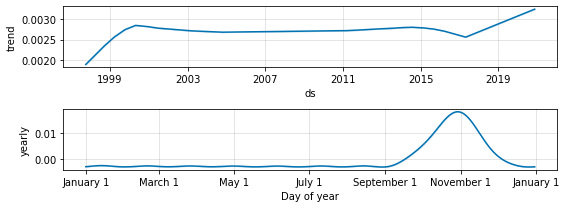

In [6]:
fig = model1.plot_components(forecast, figsize = (8, 3))
fig.savefig('model1', bbox_inches = 'tight')

In [7]:
# df = forecast[(forecast['ds'] > '2015-01-01')]
model1


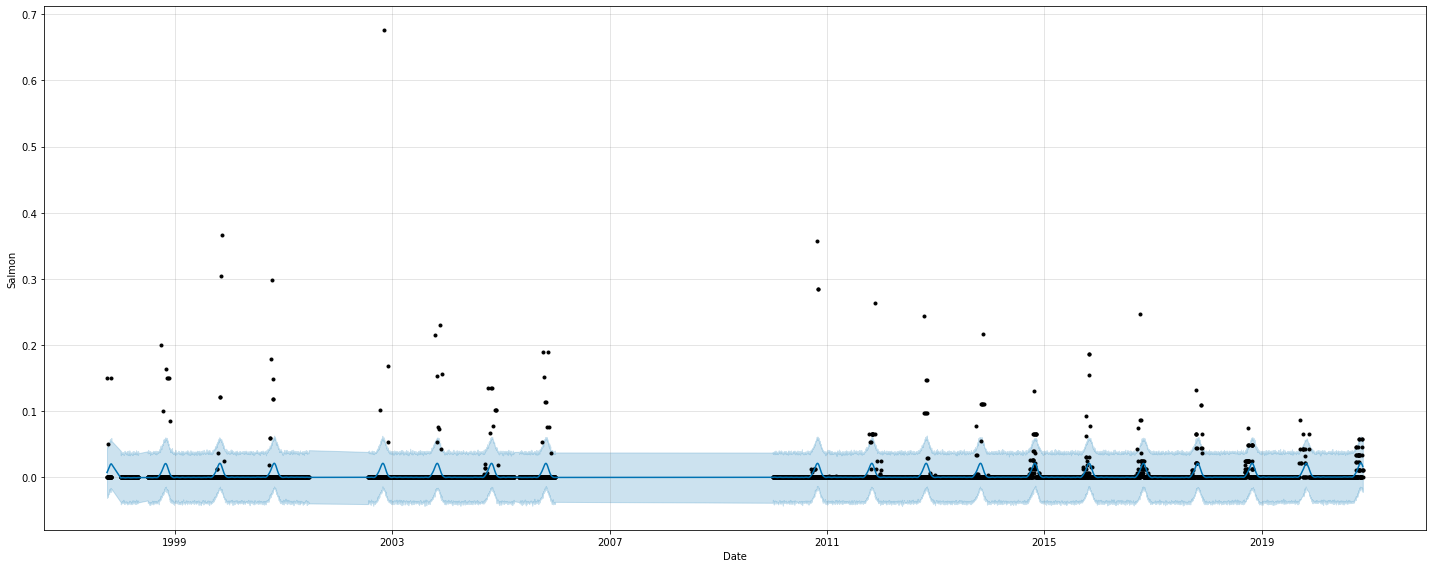

In [8]:
fig = model1.plot(forecast, xlabel = "Date", ylabel = "Salmon", figsize = (20, 8))
fig.savefig('model_pred', bbox_inches = 'tight')

In [9]:
future = model1.make_future_dataframe(periods=400, freq='D')

In [10]:
forecast = model1.predict(future)

C:\Users\austi\anaconda3\envs\prophet\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


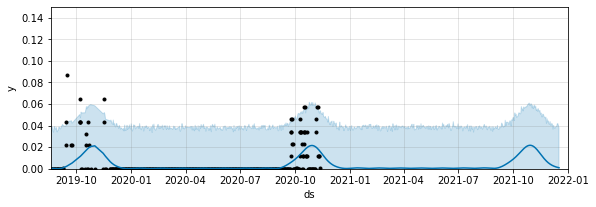

In [11]:
fig = model1.plot(forecast,figsize = (8, 3))
ax = fig.gca()
ax.set_xlim(pd.to_datetime(['2019-08-19', '2022-01-01'])) 
ax.set_ylim([0,.15])
fig.show()

In [12]:
help(Prophet.add_regressor)

Help on function add_regressor in module fbprophet.forecaster:

add_regressor(self, name, prior_scale=None, standardize='auto', mode=None)
    Add an additional regressor to be used for fitting and predicting.
    
    The dataframe passed to `fit` and `predict` will have a column with the
    specified name to be used as a regressor. When standardize='auto', the
    regressor will be standardized unless it is binary. The regression
    coefficient is given a prior with the specified scale parameter.
    Decreasing the prior scale will add additional regularization. If no
    prior scale is provided, self.holidays_prior_scale will be used.
    Mode can be specified as either 'additive' or 'multiplicative'. If not
    specified, self.seasonality_mode will be used. 'additive' means the
    effect of the regressor will be added to the trend, 'multiplicative'
    means it will multiply the trend.
    
    Parameters
    ----------
    name: string name of the regressor.
    prior_scale: op

In [13]:
df = sf.rename(columns = {"Date":"ds", "%total":"y"}, inplace = False)
futureTest = df[(df['ds'] > '2020-01-01')]
history2 = df[(df['ds'] > '1997-10-01') & (df['ds'] < '2020-01-01')]
history2

,PRCP,TMAX,TMIN,y,cfs,ds
9,0.23,63.0,51.0,0.15,4990.0,1997-10-02
10,0.58,61.0,50.0,0.00,7390.0,1997-10-03
11,0.73,58.0,54.0,0.00,24400.0,1997-10-04
12,0.13,63.0,50.0,0.00,18000.0,1997-10-05
13,0.00,63.0,44.0,0.00,8650.0,1997-10-06
...,...,...,...,...,...,...
8150,0.01,40.0,31.0,0.00,2820.0,2019-12-27
8151,0.00,43.0,33.0,0.00,2510.0,2019-12-28
8152,0.01,52.0,37.0,0.00,2290.0,2019-12-29
8153,0.15,43.0,37.0,0.00,2120.0,2019-12-30


In [46]:
m2 = Prophet(daily_seasonality = False, weekly_seasonality = False, yearly_seasonality = False, interval_width = 0.90,changepoint_prior_scale=0.5)
m2.add_regressor("cfs",mode="multiplicative",prior_scale=1,standardize=True)
m2.add_regressor("PRCP",mode="multiplicative",prior_scale=1, standardize=True)
m2.fit(history2)

In [47]:
forecast2 = m2.predict()

C:\Users\austi\anaconda3\envs\prophet\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


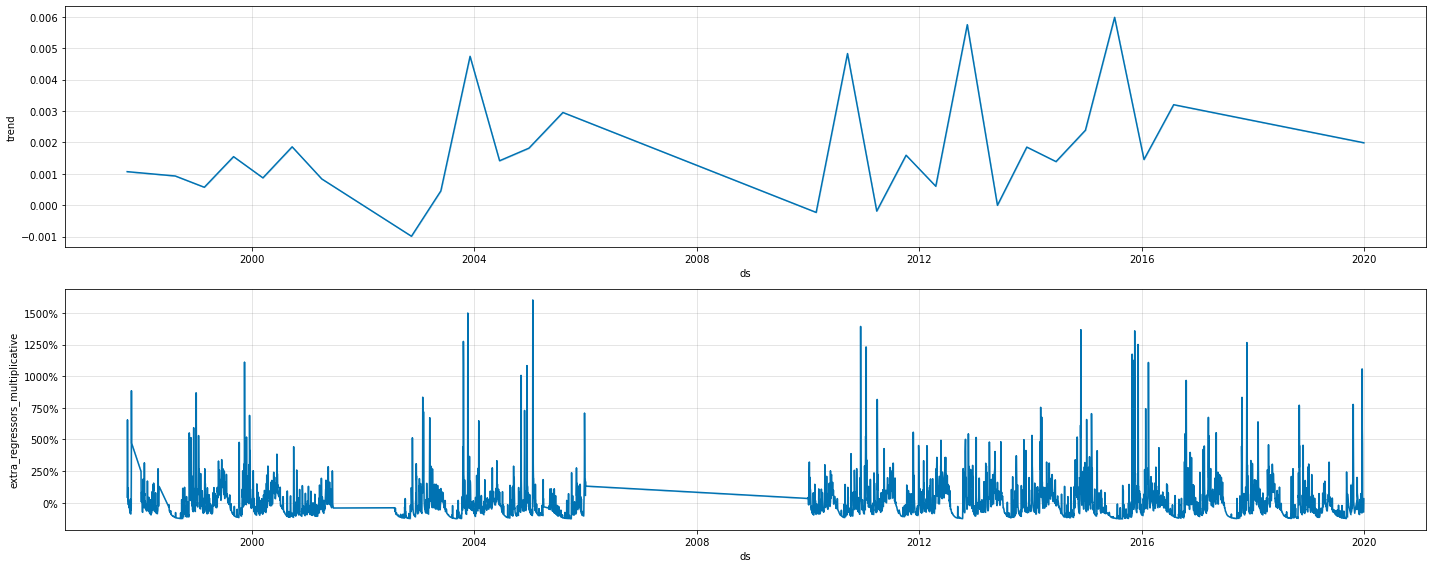

In [48]:
fig = m2.plot_components(forecast2, figsize = (20, 8))
fig.savefig('model2', bbox_inches = 'tight')

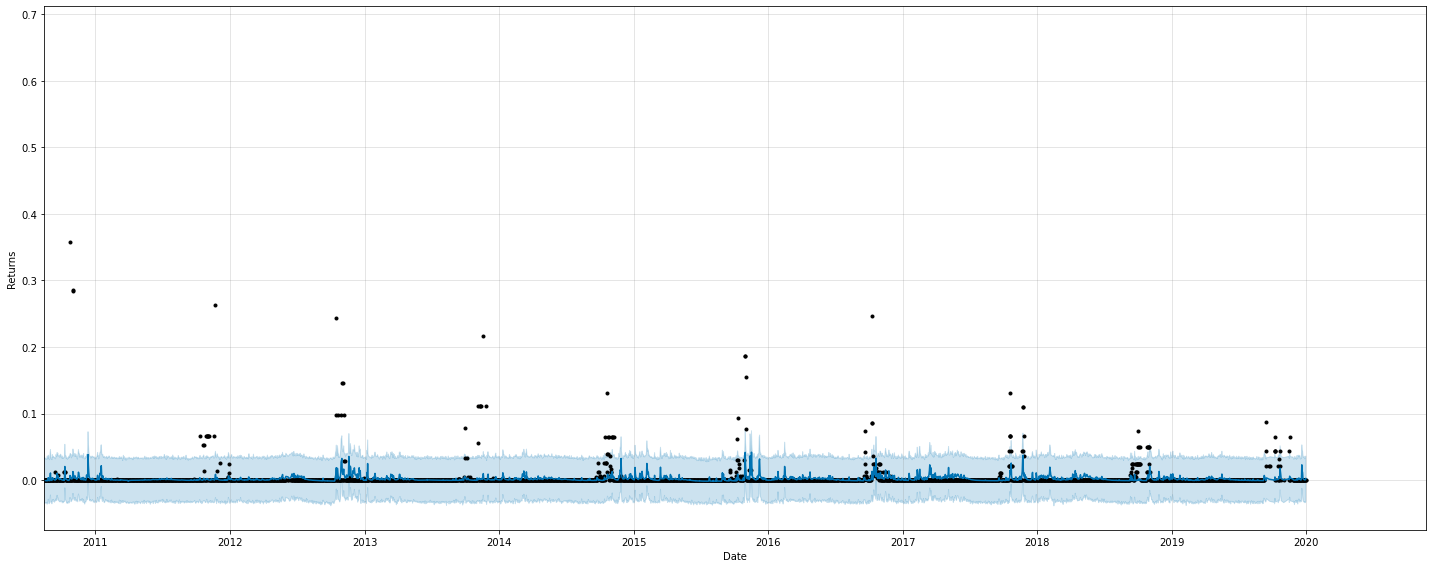

In [49]:
fig = m2.plot(forecast2, xlabel = "Date", ylabel = "Returns", figsize = (20, 8))
ax = fig.gca()
ax.set_xlim(pd.to_datetime(['2010-08-15', '2020-11-20'])) 
fig.savefig('model2_pred', bbox_inches = 'tight')

In [50]:
future2 = df[(df['ds'] > '2019-01-01')]
future2

,PRCP,TMAX,TMIN,y,cfs,ds
7783,0.03,42.0,28.0,0.000000,3480.0,2019-01-02
7784,0.72,51.0,40.0,0.000000,11000.0,2019-01-03
7785,0.18,52.0,43.0,0.000000,15500.0,2019-01-04
7786,0.02,48.0,37.0,0.000000,9110.0,2019-01-05
7787,0.30,48.0,36.0,0.000000,6320.0,2019-01-06
...,...,...,...,...,...,...
8477,0.00,46.0,27.0,0.057280,5720.0,2020-11-08
8478,0.12,46.0,25.0,0.011456,4510.0,2020-11-09
8479,0.45,41.0,35.0,0.011456,4040.0,2020-11-10
8480,0.00,41.0,32.0,0.011456,3560.0,2020-11-11


In [51]:
forecast2 = m2.predict(future2)
futureTest

,PRCP,TMAX,TMIN,y,cfs,ds
8156,0.25,43.0,35.0,0.000000,11000.0,2020-01-02
8157,0.04,58.0,38.0,0.000000,9810.0,2020-01-03
8158,0.73,50.0,33.0,0.000000,10000.0,2020-01-04
8159,0.50,50.0,36.0,0.000000,7450.0,2020-01-05
8160,0.10,49.0,37.0,0.000000,11900.0,2020-01-06
...,...,...,...,...,...,...
8477,0.00,46.0,27.0,0.057280,5720.0,2020-11-08
8478,0.12,46.0,25.0,0.011456,4510.0,2020-11-09
8479,0.45,41.0,35.0,0.011456,4040.0,2020-11-10
8480,0.00,41.0,32.0,0.011456,3560.0,2020-11-11


C:\Users\austi\anaconda3\envs\prophet\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


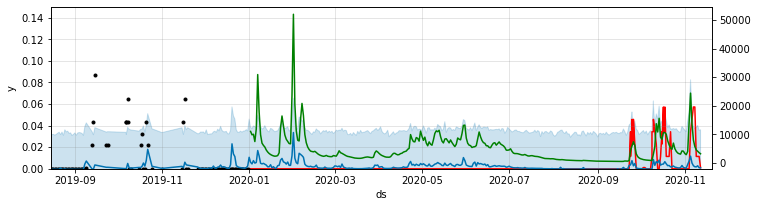

In [52]:
fig = m2.plot(forecast2,figsize = (10, 3))
ax = fig.gca()
ax.set_xlim(pd.to_datetime(['2019-08-15', '2020-11-20'])) 
ax.set_ylim([0,.15])
ax2 = ax.twinx()

ax.plot(futureTest.ds,futureTest.y, color='red',zorder=1)
ax2.plot(futureTest.ds, futureTest.cfs, color='green',zorder=-1)

fig.show()

Text(0.5, 1.0, 'Coho Salmon on Wallace River')

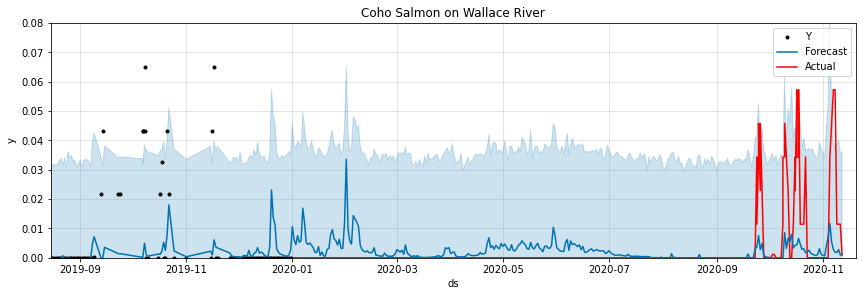

In [53]:
fig = m2.plot(forecast2,figsize = (12, 4))
ax = fig.gca()
ax.set_xlim(pd.to_datetime(['2019-08-15', '2020-11-20'])) 
ax.set_ylim([0,.08])
ax.plot(futureTest.ds,futureTest.y, color='red',zorder=1, label='Actual')
ax.legend(['Y','Forecast','Actual'])
plt.title('Coho Salmon on Wallace River')
# ax2 = ax.twinx()
# ax2.plot(futureTest.ds, futureTest.cfs, color='green',zorder=-1, label='River Discharge')


In [54]:
futureTest

,PRCP,TMAX,TMIN,y,cfs,ds
8156,0.25,43.0,35.0,0.000000,11000.0,2020-01-02
8157,0.04,58.0,38.0,0.000000,9810.0,2020-01-03
8158,0.73,50.0,33.0,0.000000,10000.0,2020-01-04
8159,0.50,50.0,36.0,0.000000,7450.0,2020-01-05
8160,0.10,49.0,37.0,0.000000,11900.0,2020-01-06
...,...,...,...,...,...,...
8477,0.00,46.0,27.0,0.057280,5720.0,2020-11-08
8478,0.12,46.0,25.0,0.011456,4510.0,2020-11-09
8479,0.45,41.0,35.0,0.011456,4040.0,2020-11-10
8480,0.00,41.0,32.0,0.011456,3560.0,2020-11-11


C:\Users\austi\anaconda3\envs\prophet\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


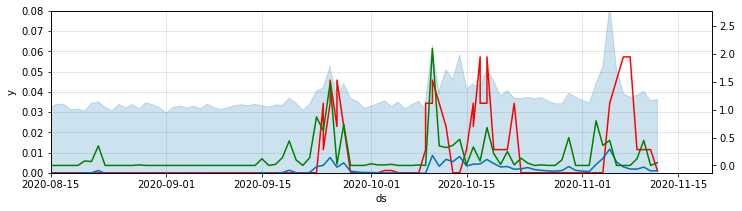

In [55]:
fig = m2.plot(forecast2,figsize = (10, 3))
ax = fig.gca()
ax.set_xlim(pd.to_datetime(['2020-08-15', '2020-11-20'])) 
ax.set_ylim([0,.08])
ax2 = ax.twinx()
ax.plot(futureTest.ds,futureTest.y, color='red',zorder=1)
ax2.plot(futureTest.ds, futureTest.PRCP, color='green',zorder=-1)
fig.show()

In [56]:
expected = futureTest[(futureTest['ds'] > '2020-09-15')]
predictions = forecast2[(forecast2['ds'] > '2020-09-15')]
predictions = predictions.yhat.to_numpy()
expected = expected.y.to_numpy()

In [57]:
forecast_errors = [expected[i]-predictions[i] for i in range(len(expected))]
print('Forecast Errors: %s' % forecast_errors)

Forecast Errors: [0.0003850059984298137, 0.00031125125647994673, -0.00013978918052654475, -0.001280603122183147, -6.051029729993452e-05, 0.00033059904355947823, -0.00018471484191328978, -0.0030209512967719733, 0.030677643415590622, 0.007765511441710456, 0.02679296956757511, 0.0382490355545152, 0.020142662043451436, 0.0430547940173316, 0.018018999686167915, -0.0007987497296974681, -0.00036553640614721863, -0.00016021794628047335, -0.00015192266030964661, -1.4158526942053509e-06, 0.0012065116063552704, 0.001209207611179379, 0.00016882298907377913, 0.00019361341696942083, 0.00021126949286922562, 0.00019079206571847107, 0.0116954891611562, 0.03460762113503637, 0.025788478648918402, 0.03724454463585849, 0.031135754516411526, 0.031135754516411526, 0.016254316500002933, -0.005518890049048867, -0.008047271612954671, 0.008063534991744484, 0.008063534991744484, 0.030114338675508737, 0.018658272688568654, 0.052899303215290974, 0.0299871712414108, 0.02776876724467526, 0.05068089921855543, 0.006863

In [58]:
forecast_errors = [expected[i]-predictions[i] for i in range(len(expected))]
bias = sum(forecast_errors) * 1.0/len(expected)
print('Bias: %f' % bias)

Bias: 0.011973


In [59]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(expected, predictions)
print('MAE: %f' % mae)

MAE: 0.013353


In [60]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(expected, predictions)
print('MSE: %f' % mse)

MSE: 0.000437


In [61]:
from sklearn.metrics import mean_squared_error
from math import sqrt

mse = mean_squared_error(expected, predictions)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 0.020895
